In [1]:
import keras
from keras.datasets import mnist
#load mnist dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data() #everytime loading data won't be so easy :)

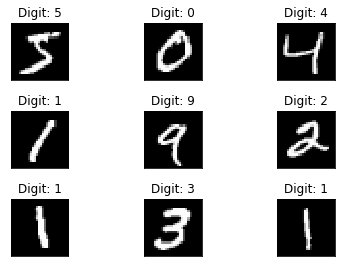

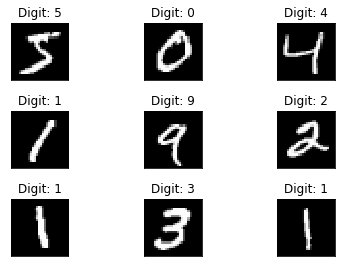

In [4]:
import matplotlib.pyplot as plt
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(X_train[i], cmap='gray', interpolation='none')
  plt.title("Digit: {}".format(y_train[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [5]:
#reshaping
#this assumes our data format
#more reshaping
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape) #X_train shape: (60000, 28, 28, 1)

X_train shape: (60000, 28, 28)


In [6]:
import keras
#set number of categories
num_category = 10
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_category)
y_test = keras.utils.to_categorical(y_test, num_category)

In [10]:
from tensorflow.keras import layers
from tensorflow.keras import models



input_shape = (28,28,1)
##model building
model = models.Sequential()
#convolutional layer with rectified linear unit activation
model.add(layers.Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
#32 convolution filters used each of size 3x3
#again
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
#64 convolution filters used each of size 3x3
#choose the best features via pooling
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
#randomly turn neurons on and off to improve convergence
model.add(layers.Dropout(0.25))
#flatten since too many dimensions, we only want a classification output
model.add(layers.Flatten())
#fully connected to get all relevant data
model.add(layers.Dense(128, activation='relu'))
#one more dropout for convergence' sake :) 
model.add(layers.Dropout(0.5))
#output a softmax to squash the matrix into output probabilities
model.add(layers.Dense(num_category, activation='softmax'))

In [11]:
#Adaptive learning rate (adaDelta) is a popular form of gradient descent rivaled only by adam and adagrad
#categorical ce since we have multiple classes (10) 
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [12]:
batch_size = 128
num_epoch = 10
#model training
model_log = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=num_epoch,
          verbose=1,
          validation_data=(X_test, y_test))

Epoch 1/10
469/469 [==============================] - 34s 71ms/step - loss: 2.2875 - accuracy: 0.1521 - val_loss: 2.2574 - val_accuracy: 0.3966
Epoch 2/10
469/469 [==============================] - 34s 73ms/step - loss: 2.2392 - accuracy: 0.2699 - val_loss: 2.1988 - val_accuracy: 0.5541
Epoch 3/10
469/469 [==============================] - 34s 72ms/step - loss: 2.1755 - accuracy: 0.3779 - val_loss: 2.1151 - val_accuracy: 0.6277
Epoch 4/10
469/469 [==============================] - 34s 72ms/step - loss: 2.0846 - accuracy: 0.4564 - val_loss: 1.9943 - val_accuracy: 0.6657
Epoch 5/10
469/469 [==============================] - 34s 72ms/step - loss: 1.9575 - accuracy: 0.5063 - val_loss: 1.8269 - val_accuracy: 0.7084
Epoch 6/10
469/469 [==============================] - 34s 73ms/step - loss: 1.7915 - accuracy: 0.5523 - val_loss: 1.6187 - val_accuracy: 0.7465
Epoch 7/10
469/469 [==============================] - 34s 73ms/step - loss: 1.6041 - accuracy: 0.5895 - val_loss: 1.3925 - val_accuracy:

In [17]:
history = model_log.history
loss=history['loss']
accuracy=history['accuracy']
val_loss=history['val_loss']
val_accuracy=history['val_accuracy']

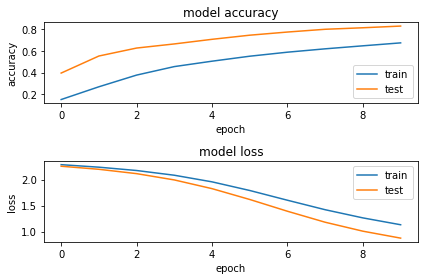

In [18]:
import matplotlib.pyplot as plt


fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.subplot(2,1,2)
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.tight_layout()

In [19]:
model.save_weights("model_digit.h5")
print("Saved model to disk")

Saved model to disk


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import tensorflow as tf
from tensorflow import keras
import os
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.python.client import device_lib

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input


%matplotlib inline

In [2]:
test_dir = 'FastFood/Test/'
val_dir = 'FastFood/Valid/'
train_dir = 'FastFood/Train/'

In [3]:
# Collecte the class names.
class_names = sorted(os.listdir(train_dir))
n_classes = len(class_names)

# Print
print("No. Classes : {}".format(n_classes))
print("Classes     : {}".format(class_names))

No. Classes : 10
Classes     : ['Baked Potato', 'Burger', 'Crispy Chicken', 'Donut', 'Fries', 'Hot Dog', 'Pizza', 'Sandwich', 'Taco', 'Taquito']


In [4]:
def make_cnn_model(learning_rate=0.03, size_inner=100, droprate=0.5):    
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    model = models.Sequential()
    model.add(keras.Input(shape=(150, 150, 3)))
    model.add(base_model)

    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(size_inner, activation='relu'))
    model.add(layers.Dropout(droprate))
    model.add(layers.Dense(n_classes, activation='softmax', kernel_initializer='zeros'))
    
    loss = keras.losses.CategoricalCrossentropy(from_logits=False)
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    metricsClass = [
        metrics.AUC(),
        metrics.CategoricalAccuracy(),
        metrics.Precision(),
        metrics.Recall()
    ]

    model.compile(loss=loss,\
                optimizer=optimizer,\
                metrics=metricsClass)
    
    return model

In [5]:
def create_generator(batch_size=126,**kwargs):
    train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
    train_ds = train_gen.flow_from_directory(train_dir,  batch_size=batch_size, target_size=(150,150),**kwargs)
    
    valid_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
    val_ds = valid_gen.flow_from_directory(val_dir,  batch_size=batch_size, target_size=(150,150))
    
    return train_ds,val_ds


In [6]:
def train(model,train_ds,val_ds,epochs=3,path='model'):
    checkpoint = keras.callbacks.ModelCheckpoint(
        path+'_{val_categorical_accuracy:.3f}.h5',
        save_best_only=True,
        monitor='val_categorical_accuracy',
        initial_value_threshold=0.6,
        mode='max'
    )
    history = model.fit(
        train_ds,
        epochs=epochs,
        validation_data=val_ds,
    #    callbacks=[checkpoint]
    )
    return history

In [9]:
train_ds,val_ds = create_generator(256)

Found 2209 images belonging to 10 classes.
Found 1148 images belonging to 10 classes.


In [10]:
train_ds.class_indices


{'Baked Potato': 0,
 'Burger': 1,
 'Crispy Chicken': 2,
 'Donut': 3,
 'Fries': 4,
 'Hot Dog': 5,
 'Pizza': 6,
 'Sandwich': 7,
 'Taco': 8,
 'Taquito': 9}

In [11]:
scores = {}

for ind,size_inner in enumerate([50,100,150]):
    print(size_inner)
    epochs =12
    filename = f'xception_v1_size_{size_inner}' 

    model = make_cnn_model(learning_rate=0.004, size_inner=size_inner, droprate=0.0)
    history = train(model,train_ds,val_ds,epochs,filename)
    scores[size_inner] = history.history

    print()
    print()

50
Epoch 1/12


c:\Users\user\.virtualenvs\Capstone_1-1Zn1mtGM\lib\site-packages\PIL\Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


9/9 [==============================] - 44s 5s/step - loss: 1.9754 - auc: 0.7519 - categorical_accuracy: 0.3422 - precision: 0.9076 - recall: 0.0489 - val_loss: 1.5757 - val_auc: 0.8734 - val_categorical_accuracy: 0.5139 - val_precision: 0.8316 - val_recall: 0.1376
Epoch 2/12
9/9 [==============================] - 41s 5s/step - loss: 1.1142 - auc: 0.9320 - categorical_accuracy: 0.6442 - precision: 0.8687 - recall: 0.4165 - val_loss: 1.2440 - val_auc: 0.9105 - val_categorical_accuracy: 0.5880 - val_precision: 0.7786 - val_recall: 0.4808
Epoch 3/12
9/9 [==============================] - 41s 5s/step - loss: 0.8352 - auc: 0.9595 - categorical_accuracy: 0.7121 - precision: 0.8475 - recall: 0.6188 - val_loss: 1.2026 - val_auc: 0.9202 - val_categorical_accuracy: 0.6141 - val_precision: 0.7451 - val_recall: 0.5348
Epoch 4/12
9/9 [==============================] - 41s 5s/step - loss: 0.6775 - auc: 0.9733 - categorical_accuracy: 0.7732 - precision: 0.8678 - recall: 0.6981 - val_loss: 1.1487 - val

In [12]:
score_size_50 = scores[50]
score_size_100 = scores[100]
score_size_150 = scores[150]

In [23]:
score_size_50['val_categorical_accuracy']

[0.5139372944831848,
 0.5879790782928467,
 0.6141114830970764,
 0.6350173950195312,
 0.6480836272239685,
 0.6515679359436035,
 0.6550522446632385,
 0.6550522446632385,
 0.645470380783081,
 0.6515679359436035,
 0.6463414430618286,
 0.657665491104126]

In [19]:
scores =  [score_size_50,score_size_100,score_size_150]

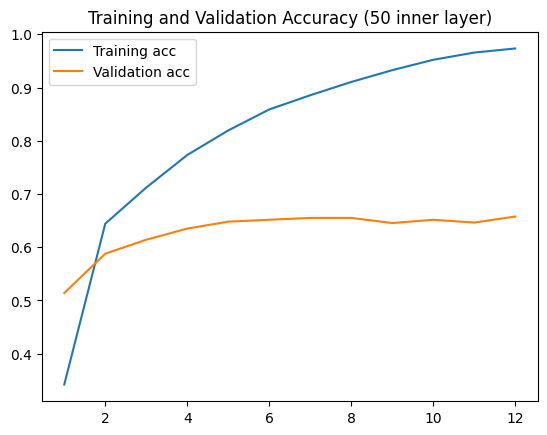

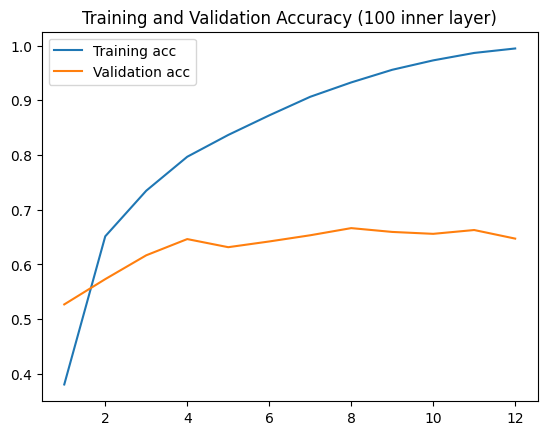

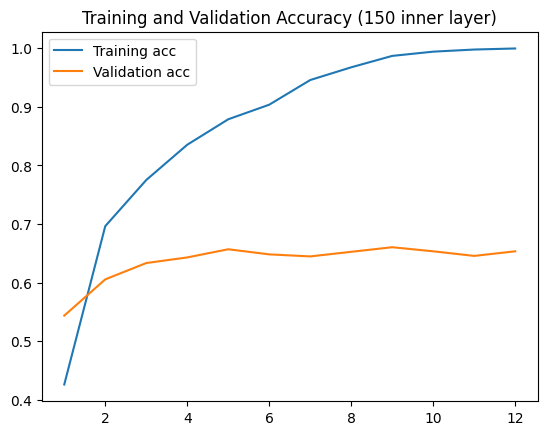

In [26]:
layer_s = [50,100,150]
for s,l in zip(scores,layer_s):
    acc = s['categorical_accuracy']
    val_acc= s['val_categorical_accuracy']
    epochs_iter = list(range(1,len(acc)+1))
    
    plt.plot(epochs_iter, acc, label='Training acc')
    plt.plot(epochs_iter, val_acc, label='Validation acc')

    plt.title(f'Training and Validation Accuracy ({l} inner layer)')
    plt.legend()
    plt.show()

In [ ]:
scores = {}

for ind,drop_rate in enumerate([0.0,0.25,0.5]):
    print(drop_rate)
    epochs =6
    filename = f'xception_v2_drop_{drop_rate}' 

    model = make_cnn_model(learning_rate=0.003, size_inner=50, droprate=drop_rate)
    history = train(model,train_ds,val_ds,epochs,filename)
    scores[size_inner] = history.history

    print()
    print()